# Explainable AI

Making models is really cool, but in practice, in businesses people often also want to know why a certain prediction was made. Understanding why predictions are made is the field of Explainable AI. It can be as important, and in some cases, even more important as making the most accurate prediction. 

SHAP (SHapley Additive exPlainations) is a game theoretic approach to explain the output of any machine learning model to increase transparency and interpretability of machine learning models. Consider a coooperative game with the same number of players as the name of features. SHAP will disclose the individual contribution of each player (or feature) on the output of the model, for each example or observation.

*Important: while SHAP shows the contribution or the importance of each feature on the prediction of the model, it does not evaluate the quality of the prediction itself.*

SHAP can thus be applied to all kinds of models. SHAP has different ways of working for different kinds of models, in this notebook we will first go through SHAP for tabular data. We will first make an XG Boost model, which is a tree model. We will use the breast_cancer dataset that has 30 variables and 1 target which is binary and shows whether the person has breast cancer or not. SHAP will help us understand which of these 30 variables made the largest difference in a single prediction. If we calculate the mean SHAP values over all these samples, we can say which of the variables are most important.

In [1]:
import sys
from pathlib import Path
# note that src dir is now THREE levels up instead of TWO!
srcdir = str(Path("../../..").resolve())
sys.path.insert(0, srcdir)
srcdir

'/Users/rgrouls/code/ML22'

In [2]:
from sklearn import datasets
import pandas as pd
import numpy as np
import shap
import torch

/Users/rgrouls/Library/Caches/pypoetry/virtualenvs/deep-learning-HUU8cknU-py3.9/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/rgrouls/Library/Caches/pypoetry/virtualenvs/deep-learning-HUU8cknU-py3.9/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#depr

In [3]:
sys.path

['/Users/rgrouls/code/ML22',
 '/Users/rgrouls/code/ML22/notebooks/7_whatsnext/explainable',
 '/Users/rgrouls/.pyenv/versions/3.9.16/lib/python39.zip',
 '/Users/rgrouls/.pyenv/versions/3.9.16/lib/python3.9',
 '/Users/rgrouls/.pyenv/versions/3.9.16/lib/python3.9/lib-dynload',
 '',
 '/Users/rgrouls/Library/Caches/pypoetry/virtualenvs/deep-learning-HUU8cknU-py3.9/lib/python3.9/site-packages']

In [4]:
from src.data.make_dataset import get_breast_cancer_dataset

train_perc = 0.8
traindataset, testdataset, featurenames = get_breast_cancer_dataset(train_perc)

len(traindataset), len(testdataset)

(455, 114)

In [5]:
from src.data.make_dataset import BaseDatastreamer

def preprocessor(batch):
    X, Y = zip(*batch)
    return torch.stack(X), torch.tensor(Y)

trainstreamer = BaseDatastreamer(traindataset, batchsize=32, preprocessor=preprocessor).stream()
teststreamer = BaseDatastreamer(testdataset, batchsize=len(testdataset), preprocessor=preprocessor).stream()

In [6]:
X, Y = next(trainstreamer)
X.shape, Y.shape

(torch.Size([32, 30]), torch.Size([32]))

In [7]:
import torch.optim as optim
from src.models import metrics
from src.models import train_model
from src.models.linear import NeuralNetwork
from src.settings import TrainerSettings, ReportTypes
from pathlib import Path


config = {
    "input" : 30,
    "h1" : 20,
    "h2" : 10,
    "output" : 2
}

model = NeuralNetwork(config)

loss_fn = torch.nn.CrossEntropyLoss()
accuracy = metrics.Accuracy()

log_dir= Path("../../models/test").resolve()

settings = TrainerSettings(
    epochs=50,
    metrics=[accuracy],
    logdir=log_dir,
    train_steps=int(train_perc * len(traindataset)) // 32,
    valid_steps=1,
    reporttypes=[ReportTypes.TENSORBOARD],
    scheduler_kwargs={"factor": 0.5, "patience": 5},
)

trainer = train_model.Trainer(
    model=model, 
    settings=settings, 
    loss_fn=loss_fn,
    optimizer=optim.Adam, 
    traindataloader=trainstreamer, 
    validdataloader=teststreamer, 
    scheduler=optim.lr_scheduler.ReduceLROnPlateau
    )

trainer.loop()

2023-06-11 14:04:37.069 | INFO     | src.data.data_tools:dir_add_timestamp:146 - Logging to /Users/rgrouls/code/ML22/notebooks/models/test/20230611-1404
2023-06-11 14:04:37.070 | INFO     | src.models.train_model:__init__:108 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 11/11 [00:00<00:00, 90.43it/s]
2023-06-11 14:04:37.268 | INFO     | src.models.train_model:report:210 - Epoch 0 train 3.8654 test 0.5382 metric ['0.7632']
100%|██████████| 11/11 [00:00<00:00, 411.72it/s]
2023-06-11 14:04:37.310 | INFO     | src.models.train_model:report:210 - Epoch 1 train 1.3995 test 0.5618 metric ['0.7544']
2023-06-11 14:04:37.311 | INFO     | src.models.train_model:__call__:247 - best loss: 0.5382, current loss 0.5618. Counter 1/10.
100%|██████████| 11/11 [00:00<00:00, 252.41it/s]
2023-06-11 14:04:37.367 | INFO     | src.models.train_model:report:210 - Epoch 2 train 0.6308 test 0.3798 metric ['0.8596']
100%|██████████| 11/11 [00:00<00:00, 284.18it/

We have a model! Now we can start using the SHAP values to analyze the model

Because we are using a Neural network, we are using the DeepExplainer.

In [8]:
import shap
import pandas as pd

X, Y = next(teststreamer)
explainer = shap.DeepExplainer(model, X)
shap_values = explainer.shap_values(X)

#make a dataframe of the data so that we can add the feature names in our plots
df = pd.DataFrame(X.numpy(), columns=featurenames)


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


### Visualize a single prediction

We can visualize a single prediction. 

For this we can use the force plot, which is a way to see the effect of each feature on the prediction, for a given observation. In this plot the positive SHAP values are displayed on the left side and the negative on the right side, as if competing against each other. The highlighted value is the prediction for that observation.



In [12]:
Y

tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
       dtype=torch.uint8)

['0.8880', '0.5351']

In [28]:
print(f"The input data has shape {X.shape}")
print(f"This means we have {X.shape[0]} samples and {X.shape[1]} features")
print("The labels are either 0 or 1, so we have two classes")
vals = [f"{x:.2f}" for x in explainer.expected_value]
print(f"We have {vals} as the expected values for either class")

The input data has shape torch.Size([114, 30])
This means we have 114 samples and 30 features
The labels are either 0 or 1, so we have two classes
We have ['0.89', '0.54'] as the expected values for either class


<ol>
    <li>The output value is the prediction for that observation </li>
    <li>The base value: the mean prediction, or mean(yhat)</li>
    <li>Red/blue: Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.</li>
    <li>The plot is centered on the x-axis at explainer.expected_value. All SHAP values are relative to the model's expected value like a linear model's effects are relative to the intercept.</li>
<ol>


In [31]:
import pandas as pd

#init javascript in order to display the visuals
shap.initjs()


category = 1
observation = 3

print(Y[observation])
shap_value = np.array(shap_values[category][observation, :])
features = df.iloc[observation,:]
shap.force_plot(explainer.expected_value[category], shap_value, features)

tensor(1, dtype=torch.uint8)


### Bar chart of mean importance

This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

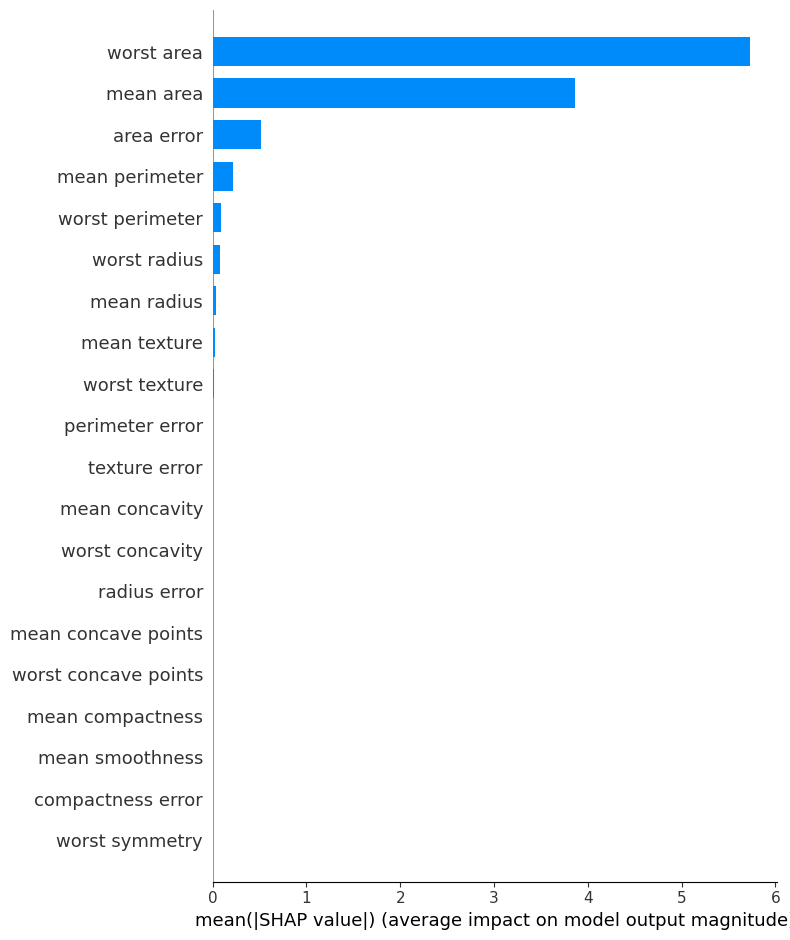

In [33]:
shap.summary_plot(shap_values[1], df, plot_type="bar")

### SHAP Summary Plot

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don’t fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


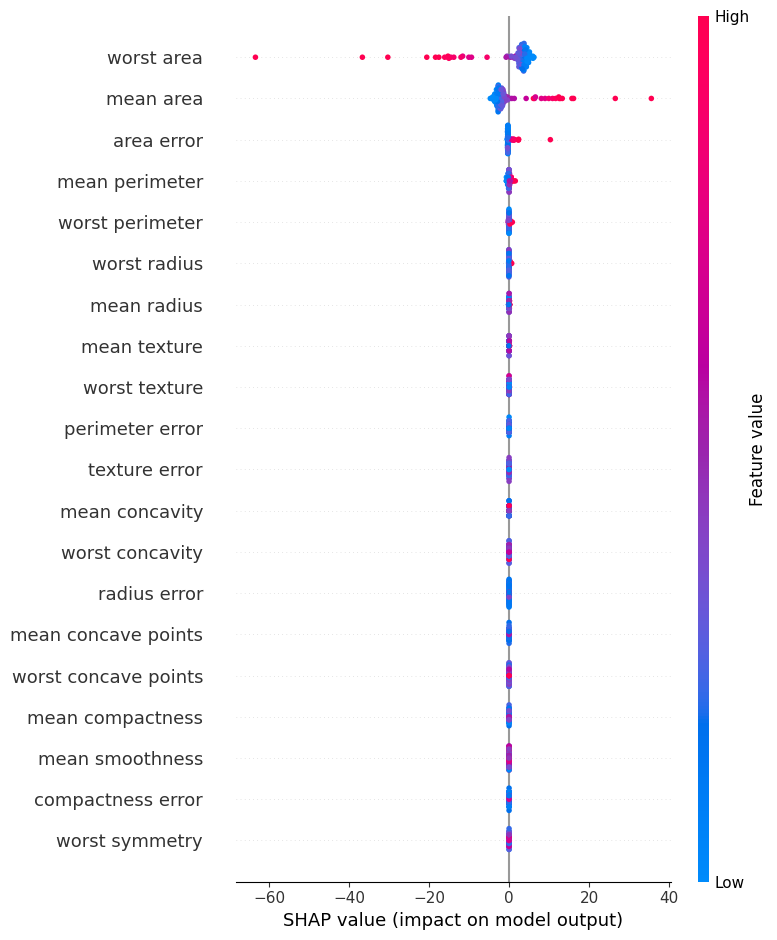

In [34]:
shap.summary_plot(shap_values[1], df)

So that's it for the tabular data. We can also use SHAP for images. See the next notebook for SHAP on image data.